# Introduction

Topological Data Analysis is a method to simplify highly complex and many-dimensional data.
It does this by clustering datapoints and considering the connections between them. This was
first used by Singh, Mémoli and Carlson in 2007 with the `Mapper` algorithm.<cite data-cite="Singh2007">(Singh, 2008)</cite>
More recently, it has been implemented in a variety of packages such as (...list...)
In this work, I use the `KeplerMapper` implementation in `Python`.<cite data-cite="KeplerMapper">(KeplerMapper)</cite>

## Related Works
Discuss `FIFA` paper, BitterSweet Forest, etc.
Do a literature review.

# Theory and Computational Method
## Theory
In this section, I will discuss the theory of topological data
analysis. A simple figure demonstrating it will be helpful,
as well as some maths chat. The Fibres of Failure paper 
is good for that!

## Computational Method
All of the computational work in this report was done using `Python 3.7` and the Jupyter notebook.
This was chosen because of the range of available software packages, and its ease of use.

In [2]:
import pickle
import sys
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import IPython
from IPython.display import SVG, IFrame

In [3]:
DESIRED_TARGETS = ["CHEMBL240"]

# To ensure repeatability of runs, the random seed should
# be consistent.
RANDOM_STATE = 2019
RENEW_MATRIX = False
# Data splitting hyperparameters.
TRAIN_RF_FRACTION = 0.60
TRAIN_FIFA_FRACTION = 0.20
VALIDATE_FRACTION = 1.0 - TRAIN_FIFA_FRACTION - TRAIN_RF_FRACTION

# Community detection hyperparameters.
# Discard any with too small a set of nodes,
# or too small a prediction error.
COMMUNITY_SIZE_CUTOFF = 3
COMMUNITY_ERROR_CUTOFF = 0.05
CORRECTION_STD_WARN = 0.10

The dataset used in this work was taken from a sanitised version of the ChEMBL database created by Lenselink *et al*. <cite data-cite="Gaulton2012">(Gaulton, 2012)</cite><cite data-cite="Lenselink2017">(Lenselink, 2017)</cite> This dataset contains only the entries in ChEMBL that have minimal experimental error, confident numerical ratings and no duplicate measurements. From this dataset, I used RDKit to parse chemical information into a computationally-accessible format.<cite data-cite="rdkit">(RDKit)</cite> The drugs were converted into SMILES strings, and their chemical fingerprints were calculted using a Morgan Fingerprinting algorithm with
a fingerprint radius of 3 bonds and a fingerprint size of 2048 bits.

In [4]:
ACTIVITY_CUTOFF = 5.4

In the dataset, activity is quantified by a `pChEMBL` value, which is logarithmic and ranges between 1 and 10. Examples in the literature often demarcate "active" vs "inactive" at `pChEMBL = 5.0`, but this classifies 90% of 
compounds in the dataset as active. Instead, `pChEMBL = 6.5` is used as a cutoff.

In [5]:
FP_SIZE = 2048

In [6]:
import rdkit
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import DataStructs

In [7]:
input_location = "../data/processed/curated_set_with_publication_year.pd.pkl"
with open(input_location, "rb") as infile:
    df = pickle.load(infile)

possible_targets = Counter([item for item in df["TGT_CHEMBL_ID"]])
possible_drugs = Counter([item for item in df["CMP_CHEMBL_ID"]])

In [8]:
fingerprint_dict = {}
for index, row in df.iterrows():
    target = row["TGT_CHEMBL_ID"]
    if target in DESIRED_TARGETS:
        drug = row["CMP_CHEMBL_ID"]
        molec = Chem.MolFromSmiles(row["SMILES"])
        fingerprint_dict[drug] = AllChem.GetMorganFingerprintAsBitVect(molec,
                                                                       radius=3,
                                                                       nBits=FP_SIZE)

I used KeplerMapper to perform the topological data analysis.\cite{KeplerMapper} This is a free and open source
implementation of the Mapper algorithm which runs in `Python`. To do further graph manipulations including community detection, I used the `igraph` package.\cite{igraph}

In [9]:
import kmapper as km
import igraph

Topological data analysis requires an algorithm to cluster the datapoints into nodes. I used the HDBSCAN algorithm
to perform this task, because it is designed to cope well with varying densities of data points. This is important for analysis of chemical space, because the density of experimental data is often inconsistent.<cite data-cite="McInnes2017">(McInnes, 2017)</cite>

In [10]:
import hdbscan
clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=3, min_samples=1)

Finally, I used Scikit-Learn to do to the machine learning in this work.<cite data-cite="scikit-learn">(Scikit-Learn)</cite>

In [11]:
import sklearn.ensemble
from sklearn.manifold import MDS

# Qualitative Results
## Exploring Chemical Space
One powerful way to use topological data analysis is to explore the similarities in chemical space in a human-readable form. To do so, we must quantify the "distance" between two compounds in chemical space. I have
chosen to do so with the Tanimoto Similarity, which is
\begin{equation}
   d_T = \frac{M_{11}}{M_{10} + M_{01} - M_{11}}
\end{equation}
with $ M_{11} $ being the number of shared 1s in two fingerprints and $M_{10} + M_{01} $ being the number of 1s in one fingerprint but not in the other.

Generating the distance matrix for a set of compounds is an $ \mathcal{O}\left(N^2\right) $ operation in both time and memory. The
distance matrix calculation was the limiting factor for the amount of data I could analyse.

In [12]:
chem_space_df = df[np.logical_or.reduce([df["TGT_CHEMBL_ID"] == tgt
                                         for tgt in DESIRED_TARGETS])]
chem_space_df = sklearn.utils.shuffle(chem_space_df,
                                      random_state=RANDOM_STATE)

In [13]:
if RENEW_MATRIX:
    distance_matrix = np.zeros([len(chem_space_df), len(chem_space_df)])
    for index in range(len(chem_space_df)):
        drug = chem_space_df.iloc[index]["CMP_CHEMBL_ID"]
        fp_1 = fingerprint_dict[drug]
        for other_index in range(index):
            other_drug = chem_space_df.iloc[other_index]["CMP_CHEMBL_ID"]
            fp_2 = fingerprint_dict[other_drug]
            distance = 1.0 - rdkit.DataStructs.TanimotoSimilarity(fp_1, fp_2)
            distance_matrix[index, other_index] = distance
            distance_matrix[other_index, index] = distance
    pickle.dump(distance_matrix, open("chemical-space-distance.pkl", "wb"))
else:
    with open("chemical-space-distance.pkl", "rb") as pklfile:
        distance_matrix = pickle.load(pklfile)

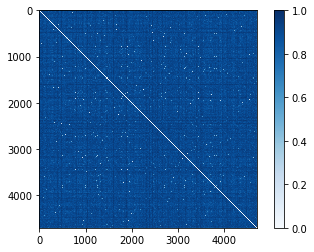

In [14]:
%matplotlib inline
plt.imshow(distance_matrix, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.savefig("./Figures/distance_matrix.pdf")

The key feature of topological data analysis that makes it useful to explore chemical space is that it shows low-dimensional data while keeping the links of high-dimensional data. Here, I use Multi-Dimensional Scaling (MDS) to reduce the dimensionality of the data to two principal components. MDS works very similarly to principal component analysis, but is applicable to more general spaces (such as non-metric chemical space).<cite data-cite="Martin2015">(Martin, 2015)</cite>

In [15]:
mds_coordinate = MDS(n_components=2,
                     dissimilarity="precomputed",
                     metric=False).fit_transform(distance_matrix)

We can also colour the graph by calculated properties to make it obvious if the clusters have shared features. For example, here is a colouring by the activity of a drug.

In [16]:
activities = np.zeros([len(chem_space_df)])
for i in range(len(chem_space_df)):
    activities[i] = chem_space_df.iloc[i]["BIOACT_PCHEMBL_VALUE"]

One of the weaknesses of the TDA technique is the degree of parameterisation. The clusterer and the cover used to construct the graph are both heavily parameterised, and these parameters can be tweaked cause great variation in the graphs produced.

In [17]:
cover = km.Cover(n_cubes=[20, 20, 10], perc_overlap=[0.30, 0.30, 0.10])
lens = np.concatenate([mds_coordinate, activities.reshape(-1, 1)], axis=1)

In [18]:
mapper = km.KeplerMapper(verbose=1)
graph = mapper.map(lens,
                   X=distance_matrix,
                   precomputed=True,
                   cover=cover,
                   clusterer=clusterer)
html_filename = "mb-map-drug-similarity.html"
mapper.visualize(graph,
                 path_html=html_filename,
                 title="Topological Data Analysis of drugs against CHEMBL240",
                 color_function=activities)
IFrame(html_filename, 800, 600)

KeplerMapper(verbose=1)
Mapping on data shaped (4703, 4703) using lens shaped (4703, 3)

Creating 4000 hypercubes.

Created 920 edges and 594 nodes in 0:00:01.559041.
Wrote visualization to: mb-map-drug-similarity.html


The graphs produced by the TDA technique require some careful interpretation. Physical proximity in the graph doesn't imply any similarity in the points. Instead, the links are significant. The features to look out for are flares coming off a main backbone, and holes in the dataset. The flares imply groups of related clusters with a distinguishing feature from the rest of the dataset -- this is often chemically important. The holes in the graph represent regions where there is no data in chemical space. If there is a hole in a chemically active region, it may be there that are ''missing link'' chemicals that have not been studied.

## Drug Testing Space

The neither the underlying space or the lens used in TDA have to have any physical meaning. This means that TDA is useful to gain an understanding of the structure of datasets which are very abstract. Here, I will use TDA to look at which drug-target interactions have been studied in the ChEMBL database in the hope that it will make links between groups or absences clear.

Here, instead of a boolean chemical fingerprint, I am going to give each drug a "testing fingerprint". These fingerprints will be $ n_\text{targets} $ long, each each entry will be
\begin{equation}
    V_{ij} = \begin{cases} +1 \qquad\text{ if } \quad i \text{ is active against } j \\  -1 \qquad \text{if} \quad i \quad \text{ is inactive against } j \\ 0 \qquad \text{ if } \quad i \text{, } j \text{has not been tested.}\end{cases}
\end{equation}

In [19]:
vector_df = pd.DataFrame(0, columns=possible_drugs.keys(), index=possible_targets.keys(), dtype=np.int8)
for index, row in df.iterrows():
    drug = row["CMP_CHEMBL_ID"]
    target = row["TGT_CHEMBL_ID"]
    if row["BIOACT_PCHEMBL_VALUE"] > ACTIVITY_CUTOFF:
        vector_df[drug][target] = 1
    else:
        vector_df[drug][target] = -1

The distance metrics we used before can be adapted in terms of general dot products. This is not always generally applicable, and we must be careful to preserve the triangle inequality (that the distance between two points cannot be shortened by going through any third point). For example, the generalised Tanimoto distance

\begin{equation}
    \cos\theta = 1.0 - \frac{v_1 \cdot v_2}{\left|v_1\right|^2 + \left|v_2\right|^2 - v_1 \cdot v_2}   
\end{equation}
is not a valid distance metric if any elements of $ v_1 $ and $ v_2 $ are negative. Instead, the cosine distance
\begin{equation}
    \cos\theta = \frac{v_1 \cdot v_2}{\left|v_1\right|\left|v_2\right|}   
\end{equation}
is more appropriate.

In [20]:
def dissimilarity(vec1, vec2, metric="euclidean"):
    """
    Takes in two vectors with values +1 and -1. Computes how far away they are
    in according to the metric.
    Current metrics:
    - Euclidean, computes sqrt(vec1 dot vec2)
    - Cosine distance
    - Tanimoto
    """
    metric = metric.lower()
    vec1 = vec1.astype(np.int16)
    vec2 = vec2.astype(np.int16)
    if metric == "euclidean":
        distance = np.abs(vec1 - vec2)
        return np.sqrt(np.dot(distance, distance))
    
    if metric == "cosine":
        return np.dot(vec1, vec2)/(np.sqrt(np.dot(vec1, vec1) * np.dot(vec2, vec2)))
                                   
    if metric == "tanimoto":
        return 1.0 - np.dot(vec1, vec2) / (np.dot(vec1, vec1) + np.dot(vec2, vec2) - np.dot(vec1, vec2))

In [21]:
mask = vector_df.loc[DESIRED_TARGETS[0]].values != 0
drug_space_df = vector_df.T[mask]

In [22]:
if RENEW_MATRIX:
    print("Renewing matrix")
    drug_distance_matrix = np.zeros([len(drug_space_df), len(drug_space_df)])
    for index in range(len(chem_space_df)):
        drug = drug_space_df.iloc[index]
        if index % 100 == 0:
            print(index)
        for other_index in range(index):
            other_drug = drug_space_df.iloc[other_index]
            distance = dissimilarity(drug, other_drug, metric="cosine")
            drug_distance_matrix[index, other_index] = distance
            drug_distance_matrix[other_index, index] = distance
    pickle.dump(drug_distance_matrix, open("drug-space-distance.pkl", "wb"))
else:
    with open("drug-space-distance.pkl", "rb") as pklfile:
        drug_distance_matrix = pickle.load(pklfile)

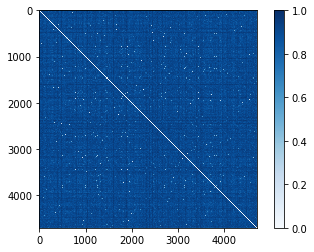

In [23]:
%matplotlib inline
plt.imshow(distance_matrix, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()
drug_distance_matrix = distance_matrix
pickle.dump(drug_distance_matrix, open("drug-space-distance.pkl", "wb"))
plt.savefig("./Figures/distance_matrix.pdf")

In [24]:
mds_coordinate = MDS(n_components=2,
                     dissimilarity="precomputed",
                     metric=False).fit_transform(drug_distance_matrix)

In [25]:
cover = km.Cover(n_cubes=[20, 20], perc_overlap=[0.30, 0.30])
lens = mds_coordinate

In [26]:
mapper = km.KeplerMapper(verbose=1)
graph = mapper.map(lens,
                   X=drug_distance_matrix,
                   precomputed=True,
                   cover=cover,
                   clusterer=clusterer)
html_filename = "mb-map-drug-testing.html"
mapper.visualize(graph,
                 path_html=html_filename,
                 title="Topological Data Analysis of drug testing space")
IFrame(html_filename, 800, 600)

KeplerMapper(verbose=1)
Mapping on data shaped (4703, 4703) using lens shaped (4703, 2)

Creating 400 hypercubes.

Created 1927 edges and 963 nodes in 0:00:01.277265.
Wrote visualization to: mb-map-drug-testing.html


## Fibres of Failure
### Theory
Because Topological Data Analysis simplifies complex many-dimensional data, it can be used to aid intepreting machine learning techniques. One such way to interpret machine learning techniques is the Fibres of Failure method, as proposed by Carlson *et al* in 2018.<cite data-cite="Carlson2018">(Carlson, 2018)</cite>

This method uses a lens constructed of
1. Predicted class
2. Model's confidence in predicting the correct answer
3. Model's confidence in its prediction
4. A principal component / MDS on the original dataset
By using this lens, the FiFa technique ensures that the prediction failures of the model are well separated from the prediction successes in topological space. A TDA graph is then constructed, and communities of failure are visible. These communities of failure can be identified either by eye with the aid of a colouring function based on prediction error, or with a programmatic community detection algorithm. In this work, I use leading eigenvector community detection.

The community detection step identifies a series of ''error classes''. These are groups of input data that the machine learning model gets wrong. A second machine learning classifier is trained to identify members of the error communities, and a correction factor is calculated as the average error in prediction of that community.

Once the error community classifier is trained, it can work in tandem with the original predictive model. A new piece of data is fed in to both, and the error community classifier will modify the output of the first model. In this way, systematic failures of the predictor are fixed in a general manner.

### Computational Method
To demonstrate this technique, I used a Random Forest classifier to predict whether a given drug will be active against `CHEMBL240`. It achieved about 75-80% accuracy with little tuning, on a training set of 60% of the original data. Then, I used `igraph`'s leading eigenvector community detection to pick out error communities, which agree well with those identified by eye. Finally, I used a non-metric Support Vector Machine to classify a second training set into error communities. Any classifier could have been used here, such as Naive Bayes or any Decision Tree variant.

In [27]:
rf_split_point = int(chem_space_df.shape[0] * TRAIN_RF_FRACTION)
fifa_split_point = int(chem_space_df.shape[0] * (TRAIN_RF_FRACTION + TRAIN_FIFA_FRACTION))
validation_split_point = int(chem_space_df.shape[0] * (1.0 - VALIDATE_FRACTION))
rf_training_df = chem_space_df.iloc[:rf_split_point, :]
fifa_training_df = chem_space_df.iloc[:fifa_split_point, :]
validation_df = chem_space_df.iloc[validation_split_point:, :]

In [28]:
def convert_to_sparse(input_df):
    """
    Converts a pandas dataframe into a sparse matrix of fingerprint observations
    and a vector of activity classes.
    """
    n_samples = input_df.shape[0]
    arr = np.empty([n_samples, FP_SIZE], dtype=bool)
    is_active = np.empty([n_samples], dtype=bool)
    
    for index, (item, row) in enumerate(input_df.iterrows()):
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(row["SMILES"]),
                                                                  radius=3,
                                                                  nBits=FP_SIZE)
        DataStructs.ConvertToNumpyArray(fingerprint, arr[index, :])
        if row["BIOACT_PCHEMBL_VALUE"] < ACTIVITY_CUTOFF:
            is_active[index] = False
        else:
            is_active[index] = True

    observations = scipy.sparse.csc_matrix(arr)
    return observations, is_active

In [29]:
rf_training_observations, rf_training_is_active = convert_to_sparse(rf_training_df)
print(np.sum(rf_training_is_active), rf_training_is_active.shape)
fifa_training_observations, fifa_training_is_active = convert_to_sparse(fifa_training_df)
print(np.sum(fifa_training_is_active), fifa_training_is_active.shape)
validation_observations, validation_is_active = convert_to_sparse(validation_df)
print(np.sum(validation_is_active), validation_is_active.shape)

1365 (2821,)
1826 (3762,)
480 (941,)


In [83]:
model = sklearn.ensemble.RandomForestClassifier(n_estimators=512,
                                                criterion="gini",
                                                n_jobs=4,
                                                random_state=RANDOM_STATE)
model.fit(rf_training_observations, rf_training_is_active)
print(model.score(validation_observations, validation_is_active))
print(model.score(fifa_training_observations, fifa_training_is_active))
print(model.score(rf_training_observations, rf_training_is_active))

0.7587672688629118
0.9346092503987241
0.9936192839418646


In [84]:
predictions = model.predict(fifa_training_observations)
probabilities = model.predict_proba(fifa_training_observations)
total_is_active = np.concatenate([rf_training_is_active, fifa_training_is_active, validation_is_active])

probabilities_ground_truth = np.empty(probabilities.shape[0])
probabilities_predicted = np.empty(probabilities.shape[0])

for i in range(len(probabilities)):
    is_active = int(total_is_active[i])

    probabilities_ground_truth[i] = probabilities[i][is_active]
    probabilities_predicted[i] = max(probabilities[i])

In [85]:
fifa_chemical_distance = distance_matrix[:fifa_split_point,
                                         :fifa_split_point]
fifa_mds_component = MDS(n_components=1,
                         dissimilarity="precomputed",
                         metric=False).fit_transform(fifa_chemical_distance)

(3762, 3762)


In [87]:
lens = np.empty([probabilities.shape[0], 4])
lens[:, 0] = fifa_training_is_active
lens[:, 1] = probabilities_ground_truth
lens[:, 2] = probabilities_predicted
lens[:, 3] = fifa_mds_component[:, 0]
print(100.0 * np.sum(fifa_training_is_active) / fifa_training_is_active.shape[0], "% of these compounds are active")
got_it_right = np.logical_not(np.logical_xor(fifa_training_is_active, predictions))

48.538011695906434 % of these compounds are active


In [130]:
custom_tooltips=np.array([f"<img src='./Figures/{chembl_id}.svg'>" for chembl_id in fifa_training_df["CMP_CHEMBL_ID"]])
mapper = km.KeplerMapper(verbose=1)
graph = mapper.map(lens,
                   X=fifa_chemical_distance,
                   precomputed=True,
                   cover=km.Cover(n_cubes=[2, 10, 10, 20], perc_overlap=[0.0, 0.05, 0.05, 0.35]),
                   clusterer=clusterer)
mapper.visualize(graph, path_html="mb-fibres-of-failure.html",
                 title="Testing out Fibres of Failure", color_function=probabilities_ground_truth, custom_tooltips=custom_tooltips)
IFrame("mb-fibres-of-failure.html", 800, 600)

KeplerMapper(verbose=1)
Mapping on data shaped (3762, 3762) using lens shaped (3762, 4)

Creating 4000 hypercubes.

Created 557 edges and 565 nodes in 0:00:01.232575.
Wrote visualization to: mb-fibres-of-failure.html


In [131]:
g = igraph.Graph()
vertices = list(graph["nodes"].keys())
g.add_vertices(vertices)

edges = []
for link in graph["links"]:
    edges.extend([(link, otherlink) for otherlink in graph["links"][link]])
g.add_edges(edges)

In [132]:
communities = g.community_leading_eigenvector()

flattened_nodes = []
interesting_cubes = []
for community in communities:
    if len(community) > COMMUNITY_SIZE_CUTOFF:
        node_names = [g.vs[item]["name"] for item in community]       
        interesting_cubes.append(node_names)
        temp_i_n = [graph["nodes"][node] for node in node_names]
        flattened_nodes.append(list(set([item for sublist in temp_i_n for item in sublist])))

In [133]:
error_communities = []
error_corrections = [np.array([0.0, 0.0])]
error_cubes = []
for i, community in enumerate(flattened_nodes):
    errors = []
    corrections = []
    for node in community:
        prediction_error = 1.0 - probabilities_ground_truth[node]
        errors.append(prediction_error)
        if total_is_active[node]:
            corrections.append([-prediction_error, prediction_error])
        else:
            corrections.append([prediction_error, -prediction_error])
    corrections = np.array(corrections)
    correction_mean = np.mean(corrections, axis = 0)
    correction_std = np.std(corrections, axis = 0, ddof=1)[0]
    if abs(correction_mean[0]) > COMMUNITY_ERROR_CUTOFF:
        error_cubes.append(interesting_cubes[i])
        error_corrections.append(correction_mean)
        error_communities.append(flattened_nodes[i])


highlighted_communities = np.ones(probabilities_ground_truth.shape[0])    
for community in error_communities:
    for node in community:
        highlighted_communities[node] = 0.1

In [134]:
mapper.visualize(graph, path_html="mb-fibres-of-failure-communities.html",
                 title="Testing out Fibres of Failure", color_function=highlighted_communities)
IFrame("mb-fibres-of-failure-communities.html", 800, 600)

Wrote visualization to: mb-fibres-of-failure-communities.html


In [156]:
def _repr_svg_patch_(self):
    """Returns an SVG representation of this plot as a string.

    This method is used by IPython to display this plot inline.
    """
    io = igraph.compat.BytesIO()
    cairo = igraph.drawing.utils.find_cairo()
    # Create a new SVG surface and use that to get the SVG representation,
    # which will end up in io
    surface = cairo.SVGSurface(io, self.bbox.width, self.bbox.height)
    context = cairo.Context(surface)
    # Plot the graph on this context
    self.redraw(context)
    # No idea why this is needed but python crashes without
    context.show_page()
    surface.finish()
    # Return the raw SVG representation
    result = io.getvalue()
    if hasattr(result, "encode"):
        return result.encode("utf-8")          # for Python 2.x
    else:
        return result.decode("utf-8")          # for Python 3.x


setattr(igraph.drawing.Plot, "_repr_svg_", _repr_svg_patch_)

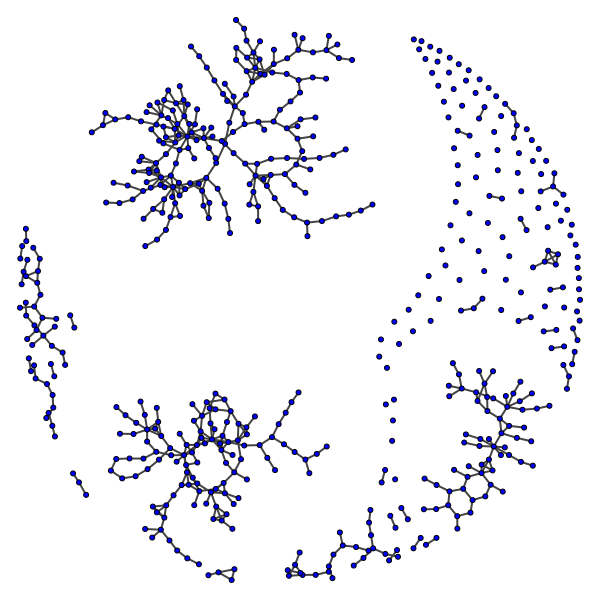

In [160]:
g2 = igraph.Graph()
vertices = list(graph["nodes"].keys())
g2.add_vertices(vertices)

edges = []
for link in graph["links"]:
    edges.extend([(link, otherlink) for otherlink in graph["links"][link]])
g2.add_edges(edges)
layout = g2.layout("kk")
igraph.plot(g2, layout = layout, vertex_color = "blue", edge_width=2.0, vertex_size=5)

## Chemical Similarity in Error Communities
This technique would be very useful if there was a set of similar chemical information in the communities of compounds that cause errors. For example, if there was a common functional group that caused the predictor to make a mistake, or a common molecular weight. However, a simple analysis of commonality in chemical fingerprints is likely to suffer from the ''look-elsewhere'' effect. There are 2048 possible bits to be set in a fingerprint, so the likelihood of any given bit (representing a functional group) to differ between two communities is high. This would just be chance and not reflectively of any chemical meaning.

Instead, we can look at whether some simple chemical properties are drawn from the same distribution. If they are drawn from different distributions, then there must be a chemical difference underpinning that. One technique to do so is the two-sample Kolmogorov-Smirnov statistic.

In [135]:
COMPARISON_PROPERTIES = ["CMP_ACD_LOGD", "CMP_ACD_LOGP", "CMP_ALOGP", "CMP_FULL_MWT", "CMP_LOGP", "BIOACT_PCHEMBL_VALUE"]
REJECTION_ALPHA = 0.05

In [138]:
differing_properties = []
for comparison_property in COMPARISON_PROPERTIES:
    molecular_properties = []
    for community in error_communities:
        molecular_properties.append(np.array([fifa_training_df.iloc[node][comparison_property] for node in community]))

    ks_statistic, p_value = scipy.stats.ks_2samp(molecular_properties[1], molecular_properties[2])

    size_n = molecular_properties[1].shape[0]
    size_m = molecular_properties[2].shape[0]
    rejection_c = np.sqrt(-0.5 * np.log(REJECTION_ALPHA))
    rejection_level = rejection_c * np.sqrt((size_n + size_n) / (size_n * size_m))
    if ks_statistic > rejection_level and p_value < REJECTION_ALPHA:
        print("We can rule out the null hypothesis at alpha =", REJECTION_ALPHA, "for", comparison_property)
        print("KS Statistic:", ks_statistic, "P-Value:", p_value)
        differing_properties.append(comparison_property)

We can rule out the null hypothesis at alpha = 0.05 for CMP_ACD_LOGD
KS Statistic: 0.47058823529411764 P-Value: 0.024540527969019055


In [139]:
for differing_property in differing_properties:
    molecular_properties = []
    for community in error_communities:
        molecular_properties.append(np.array([fifa_training_df.iloc[node][differing_property] for node in community]))
    print("For the property",differing_property,"the means are", np.mean(molecular_properties[0]), "and", np.mean(molecular_properties[1]))

For the property CMP_ACD_LOGD the means are nan and 2.5105882352941182


Here, we can see that the error communities are singificantly different in their calculated partition coefficients ($\log P $). One error group has a considerably lower $\log P $ than the other. However, this reflects one of the significant problems in the Fibres of Failure method, and topological data analysis as a whole. The properties that are selected here as being different are very sensitive to the clustering algorithm and hyperparameters. With one set of parameters (e.g. overlap and number of hypercubes), the algorithm may pick out communities differing in $\log P $. With a different set of parameters, it may pick out $ \log D $ as the differing property with no change in the underlying predictive model is it trying to correct for.

The sensitivity of results to the hyperparameters makes extracting chemical information extremely difficult from the Fibres of Failure method. There is no way to say ''The predictor is bad if the compound features an $NH_2 $ group'', or ''the predictor is bad for compounds with a high $\log P $''.

### Results
I found that the Fibres of Failure technique was not well suited to the task to predicting chemical activity. This is because the training data set is too small to effectively train both the initial predictor and the error classifier. New chemical compounds are often markedly different to those that already exist, due to the nature of patenting and competition chemical synthesis. This means that a new compound does not necessarily belong to a pre-existing failure class. With the dearth of training data available for the error community classifer, it suffers from over-predicting new drugs as members of the error communities. This classification noise can often harm the prediction accuracy.

# Conclusions

In conclusion, topological data analysis is useful for a specific class of problem. It suffers from too much parameterisation, which leads to a ''turning the handle'' approach to a problem. The parameters must be tweaked non-systematically and assessed by eye until a worthwhile result is found. However, once that worthwhile result is found it is not always easy to interpret. The layout of the graphs leads naturally to an incorrect interpretation based on proximity, but a better interpretation is based on the clusters and the links between them. However, the clustering algorithm and the underlying space it works in are often very abstract and difficult to conceptualise -- with chemical fingerprints, a 2048-dimensional space, visualising the space is essentially impossible. This means that the lens and clustering algorithm act essentially as black boxes, and may pick out clusters in the data that have no physical basis.

There are cases where the technique is powerful, and this is shown in the error analysis of the Fibres of Failure method.